In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("F1 Telemetry EDA") \
    .master("local[*]") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print("SparkSession готов")

✅ SparkSession готов


In [ ]:
df = spark.read.csv("/home/jovyan/work/TelemetryData_*.csv", header=True, inferSchema=True)

print(f"Общее количество строк: {df.count()}")
df.show(3, truncate=False)

Общее количество строк: 23642660
+-----------+---------------+-----------+--------------+--------------+--------------+--------------+--------------+--------------+----------------+----------------+----------------+--------------+--------------+--------------+-------------+------------------+--------------+-------+-------+-------+-----+--------+-----+-----+------+----+---------+---+-----------------+-----------------------+---------------------+-----------------+---------------------------+-----------+-------+----------------+----------+-----------------+-----------------------+------------------+-----------------------+--------------+-------------+-----------------------+-----------------------+------------------+-----------+--------------+-------------+-----------+-------------+---------+------+------------+------------+
|sessionTime|frameIdentifier|pilot_index|worldPositionX|worldPositionY|worldPositionZ|worldVelocityX|worldVelocityY|worldVelocityZ|worldForwardDirX|worldForwardDirY|

In [ ]:
simple_cols = [
    "speed", "throttle", "steer", "brake", "gear", "engineRPM",
    "engineTemperature", "fuelInTank", "currentLapTime", "carPosition"
]

missing_cols = [c for c in simple_cols if c not in df.columns]
if missing_cols:
    print("Отсутствующие колонки:", missing_cols)
else:
    print("Все колонки найдены")

df_simple = df.select(simple_cols)
df_simple.show(3)

✅ Все колонки найдены
+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+
|speed|throttle|steer|brake|gear|engineRPM|engineTemperature|fuelInTank|currentLapTime|carPosition|
+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+
|  0.0|     0.0|  0.0|  0.0| 0.0|   3505.0|             90.0|  58.79191|           0.0|         16|
|  0.0|     0.0|  0.0|  0.0| 0.0|   4305.0|             90.0|  57.24284|           0.0|          2|
|  0.0|     0.0|  0.0|  0.0| 0.0|   3505.0|             90.0|   59.3962|           0.0|          5|
+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+
only showing top 3 rows



In [ ]:
from pyspark.sql.functions import col, when, count

null_counts = df_simple.select([count(when(col(c).isNull(), c)).alias(c) for c in simple_cols])
null_counts.show(truncate=False)

+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+
|speed|throttle|steer|brake|gear|engineRPM|engineTemperature|fuelInTank|currentLapTime|carPosition|
+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+
|1920 |1920    |1920 |1920 |1920|1920     |1920             |4280      |0             |0          |
+-----+--------+-----+-----+----+---------+-----------------+----------+--------------+-----------+



In [ ]:
df_simple.describe().show(truncate=False)

+-------+-----------------+-------------------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|speed            |throttle           |steer              |brake              |gear             |engineRPM         |engineTemperature|fuelInTank        |currentLapTime    |carPosition      |
+-------+-----------------+-------------------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|count  |23640740         |23640740           |23640740           |23640740           |23640740         |23640740          |23640740         |23638380          |23642660          |23642660         |
|mean   |191.1162159898548|0.612915006478642  |0.00991638296009348|0.08576829282628215|4.681998998339307|10114.609243619278|90.4604822860875 |29.979233073190372|66.91568166801419 |10.5             |
|stdd

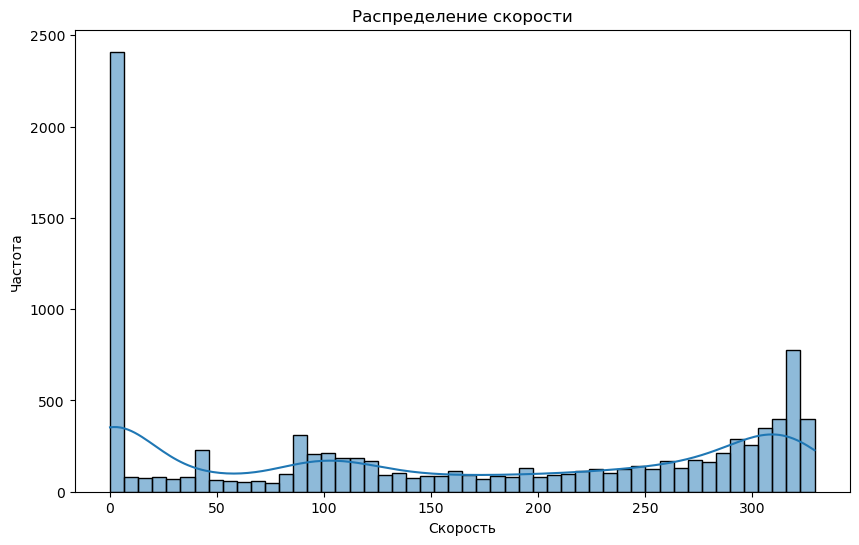

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_df = df_simple.limit(10000).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(sample_df['speed'], bins=50, kde=True)
plt.title('Распределение скорости')
plt.xlabel('Скорость')
plt.ylabel('Частота')
plt.show()

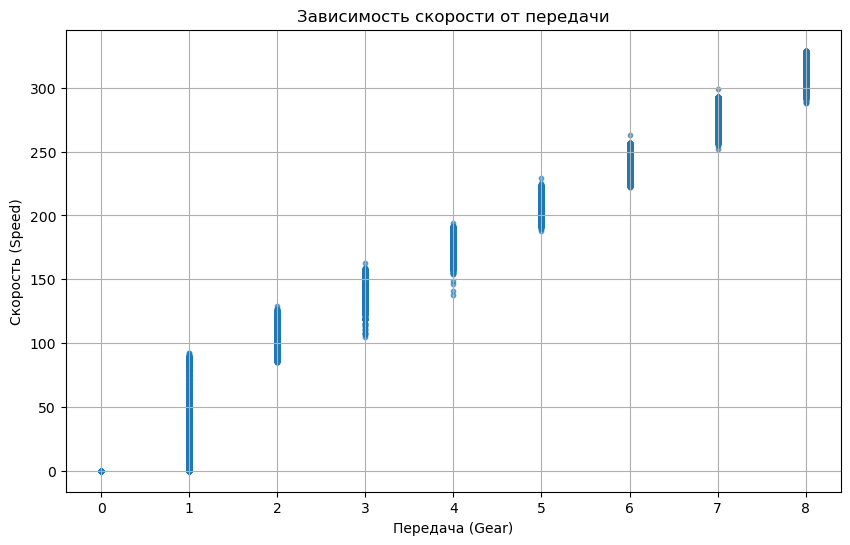

In [ ]:
import matplotlib.pyplot as plt

sample_df = df_simple.select("speed", "gear").dropna().limit(10000).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(sample_df['gear'], sample_df['speed'], alpha=0.6, s=10)
plt.title('Зависимость скорости от передачи')
plt.xlabel('Передача (Gear)')
plt.ylabel('Скорость (Speed)')
plt.grid(True)
plt.xticks(sorted(sample_df['gear'].unique())) 
plt.show()

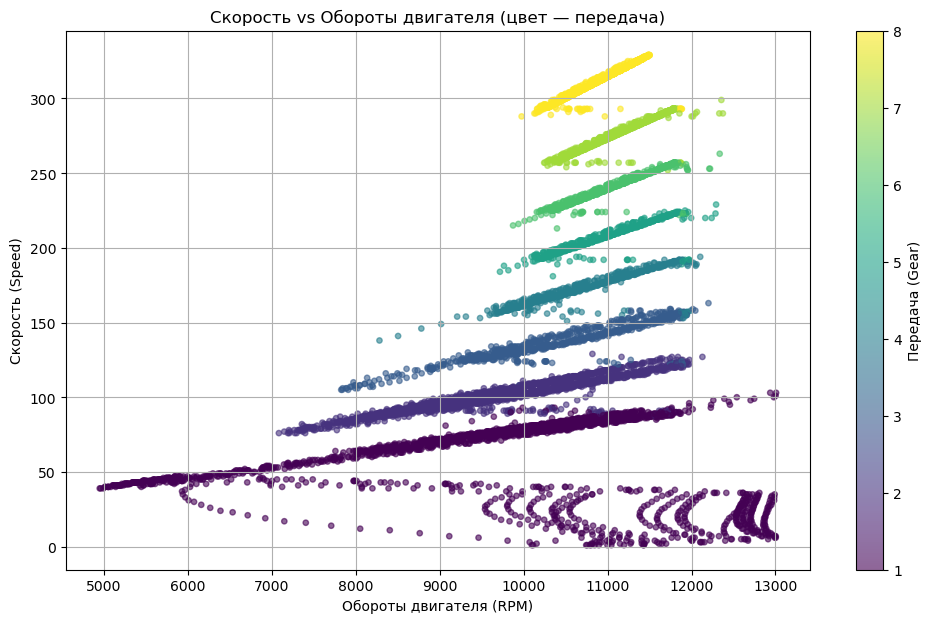

In [ ]:
import matplotlib.pyplot as plt

sample_df = df_simple.filter((col("speed") > 0) & (col("engineRPM") > 0)) \
                     .select("speed", "engineRPM", "gear") \
                     .limit(10000) \
                     .toPandas()

plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    sample_df['engineRPM'], 
    sample_df['speed'], 
    c=sample_df['gear'], 
    cmap='viridis', 
    alpha=0.6, 
    s=15
)
plt.colorbar(scatter, label='Передача (Gear)')
plt.title('Скорость vs Обороты двигателя (цвет — передача)')
plt.xlabel('Обороты двигателя (RPM)')
plt.ylabel('Скорость (Speed)')
plt.grid(True)
plt.show()

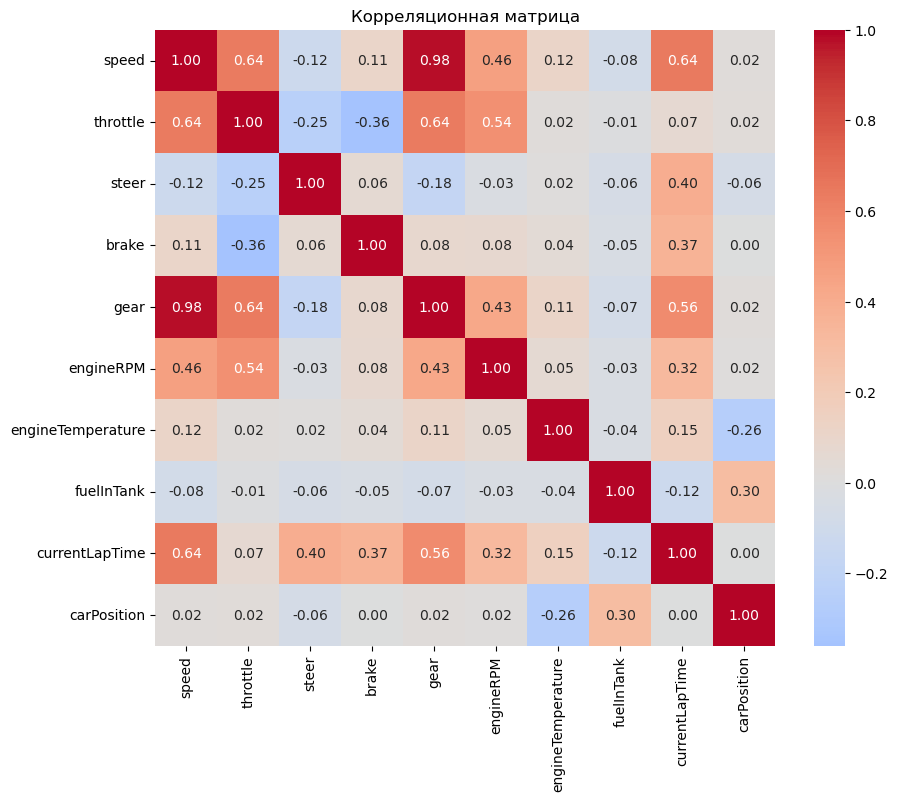

In [ ]:
corr_pandas = df_simple.limit(10000).toPandas()

correlation_matrix = corr_pandas.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()